# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [8]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(f'Number of rows demographics dataset: {len(azdias)}')
azdias.head()

Number of rows demographics dataset: 891221


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
print(f'Number of rows features info dataset: {len(feat_info)}')
feat_info.head()

Number of rows features info dataset: 85


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [57]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [14]:
# Identify missing or unknown data values and convert them to NaNs.
def replace_missing_or_unknown(row):
    value = row[column] 
    if value in cleaned_nan_to_replace:
        return None
    else:
        return value
for index, row in feat_info.iterrows():
    nan_to_replace = row['missing_or_unknown'].replace('[', '').replace(']', '')
    if nan_to_replace:
        nan_to_replace = nan_to_replace.split(',')
        cleaned_nan_to_replace = list()
        for value in nan_to_replace:
            try:
                n = int(value)
            except Exception:
                n = value
            finally:
                cleaned_nan_to_replace.append(n)
        column = row['attribute']
        azdias[column] = azdias.apply(replace_missing_or_unknown, axis=1)
    else:
        continue
            

In [35]:
# The proccess above took more than 10 minutes to run.
# better save the cleaned dataframe into a csv.
azdias.to_csv('azdias_p.csv', index=False)


In [9]:
azdias = pd.read_csv('azdias_p.csv')

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

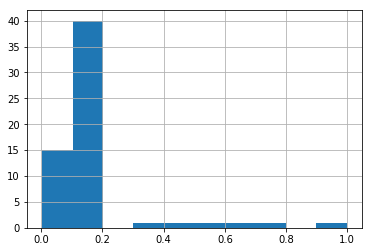

In [3]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
num_rows = azdias.shape[0]
count_missing_data = azdias.isnull().sum()
proportion_missing_data = count_missing_data[count_missing_data > 0] / num_rows
proportion_missing_data.hist()

In this case the outlayer are when the proportion of missing data is > 20%, we should investigate those rows.

In [4]:
# Investigate patterns in the amount of missing data in each column.
to_check = proportion_missing_data[proportion_missing_data > 0.2]
to_check

AGER_TYP        0.769554
GEBURTSJAHR     0.440203
TITEL_KZ        0.997576
ALTER_HH        0.348137
KK_KUNDENTYP    0.655967
KBA05_BAUMAX    0.534687
dtype: float64

In [5]:
proportion_missing_data.sort_values()

ALTERSKATEGORIE_GROB     0.003233
CJT_GESAMTTYP            0.005446
GFK_URLAUBERTYP          0.005446
ONLINE_AFFINITAET        0.005446
RETOURTYP_BK_S           0.005446
LP_STATUS_FEIN           0.005446
LP_STATUS_GROB           0.005446
HH_EINKOMMEN_SCORE       0.020587
ANZ_PERSONEN             0.082470
SOHO_KZ                  0.082470
ANZ_TITEL                0.082470
WOHNDAUER_2008           0.082470
KONSUMNAEHE              0.082997
LP_FAMILIE_GROB          0.087287
LP_FAMILIE_FEIN          0.087287
GEBAEUDETYP              0.104517
WOHNLAGE                 0.104517
OST_WEST_KZ              0.104517
MIN_GEBAEUDEJAHR         0.104517
GEBAEUDETYP_RASTER       0.104525
EWDICHTE                 0.105182
BALLRAUM                 0.105182
INNENSTADT               0.105182
LP_LEBENSPHASE_GROB      0.106115
ANZ_HH_TITEL             0.108848
ORTSGR_KLS9              0.109147
ARBEIT                   0.109260
RELAT_AB                 0.109260
LP_LEBENSPHASE_FEIN      0.109549
CAMEO_DEUG_201

In [6]:
proportion_missing_data.describe()

count    61.000000
mean      0.154033
std       0.176274
min       0.003233
25%       0.104517
50%       0.111479
75%       0.130736
max       0.997576
dtype: float64

In [10]:
outlayers = to_check.keys().tolist()
feat_info[feat_info['attribute'].isin(outlayers)]

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
11,GEBURTSJAHR,person,numeric,[0]
40,TITEL_KZ,person,categorical,"[-1,0]"
43,ALTER_HH,household,interval,[0]
47,KK_KUNDENTYP,household,categorical,[-1]
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"


In [11]:
azdias[outlayers].head()

,AGER_TYP,GEBURTSJAHR,TITEL_KZ,ALTER_HH,KK_KUNDENTYP,KBA05_BAUMAX
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1996.0,NaN,NaN,NaN,5.0
2,NaN,1979.0,NaN,17.0,NaN,NaN
3,2.0,1957.0,NaN,13.0,NaN,1.0
4,NaN,1963.0,NaN,20.0,1.0,NaN


In [18]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias = azdias.drop(outlayers, axis=1)

#### Discussion 1.1.2: Assess Missing Data in Each Column

All columns have missing data, ranging proportion between 0.003233 to 0.99. But most have less or equal to 0.13 which is good. The average is around 18%. From the histogram we can see that outlayers are values when the proportion is > 20%. The columns names are :
- **AGER_TYP**        (0.769554)
- **GEBURTSJAHR**     (0.440203)
- **TITEL_KZ**        (0.997576)
- **ALTER_HH**        (0.348137)
- **KK_KUNDENTYP**    (0.655967)
- **KBA05_BAUMAX**    (0.534687)

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [24]:
def count_missing_columns(row):
    n = 0
    for key, value in row.items():
        if str(value) != 'nan':
            continue
        else:
            n += 1
    return n

In [25]:
# How much data is missing in each row of the dataset?


count_nan_values_row = azdias.apply(count_missing_columns, axis=1)
count_nan_values_row_perc = count_nan_values_row / azdias.shape[1]

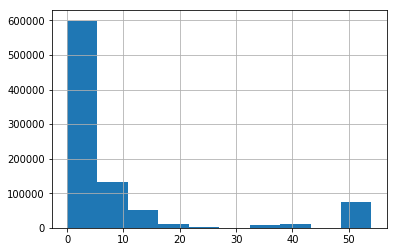

In [26]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
count_nan_values_row.hist()


In [21]:
count_nan_values_row.describe()

count    891221.000000
mean          6.171783
std           2.027998
min           0.000000
25%           6.000000
50%           7.000000
75%           7.000000
max          12.000000
dtype: float64

In [29]:

tiny_missing = azdias[count_nan_values_row <= 10]

small_missing = azdias[count_nan_values_row > 10]

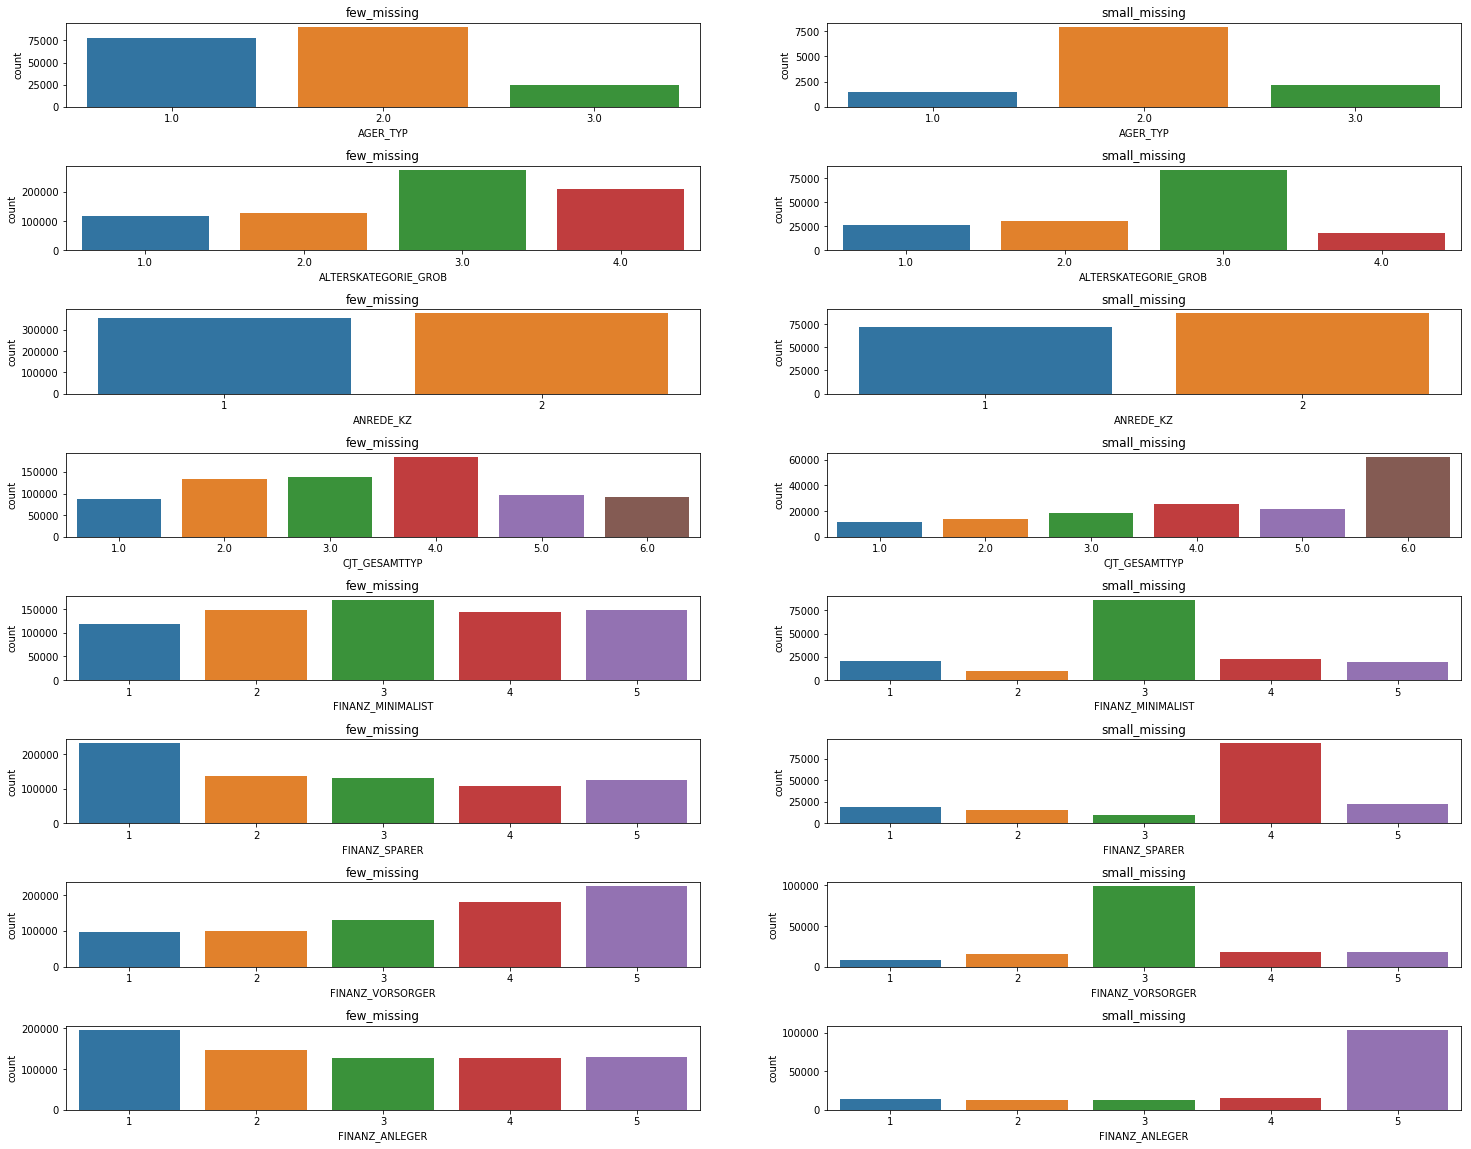

In [30]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.


col_names_few = small_missing.columns

def plot_n_columns_missing(cols, n_cols):
    
    fig, axs = plt.subplots(n_cols, 2, figsize=(25, 20))
    fig.subplots_adjust(wspace=0.2, hspace=0.7)
    axs = axs.ravel()

    for n_column in range(n_cols):
        
        index_few_missing = n_column * 2
        index_small_missing = index_few_missing + 1
        
        sns.countplot(tiny_missing[cols[n_column]], ax=axs[index_few_missing])
        axs[index_few_missing].set_title('few_missing')
        
        sns.countplot(small_missing[cols[n_column]], ax=axs[index_small_missing])
        axs[index_small_missing].set_title('small_missing')
    
    
plot_n_columns_missing(col_names_few, 8)


## Discussion 1.1.3: Assess Missing Data in Each Row

From the plot above we can see that having a treeshold of `n = 10` ( found it from creating a histogram of the count of missing values per row) the missing missing values are not really similar. So is better to proceed without rows that have more than 10 empty values.
Before going any further lets check what percentage of the data are we going to remove.

In [31]:
rows_no_missing_values = (len(azdias[count_nan_values_row == 0]) / num_rows) * 100
rows_small_missing_values = (len(small_missing) / num_rows) * 100
rows_tiny_missing_values = (len(tiny_missing) / num_rows) * 100
print(f'Percentage of rows that don\'t have missing values: {rows_no_missing_values}%')
print(f'Percentage of rows that have 7 or less missing values: {rows_tiny_missing_values}%')
print(f'Percentage of rows that have more than 7 missing values: {rows_small_missing_values}%')


Percentage of rows that don't have missing values: 0.016045402879869303%
Percentage of rows that have 7 or less missing values: 82.14842334280723%
Percentage of rows that have more than 7 missing values: 17.851576657192773%


So as we can see there are almost no rows that don't have missing values, so no much to say.
In the other hand we have the comparison of small and tiny number of missing values. When having tiny number of missing colums we hold 82.1% of the data which is not bad. Then the rest is just the 17.8%. 
We can just remove row with more than 10 missing values or keep then and replace with an average or a `0`. Either way we have to do the replace items for all missing values.
For now let's keep all the data. We will remove the unwanted rows when we create the cleaning function.

In [25]:
azdias = azdias.fillna(0)

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [113]:
# How many features are there of each data type?
feat_info.groupby('type').count()

,attribute,information_level,missing_or_unknown
type,,,
categorical,21,21,21
interval,1,1,1
mixed,7,7,7
numeric,7,7,7
ordinal,49,49,49


In [58]:
feat_info[feat_info['type'] == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [26]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
# Re-encode categorical variable(s) to be kept in the analysis.

from sklearn.preprocessing import OneHotEncoder

to_remove = list()
categorical_columns_info = feat_info[feat_info['type'] == 'categorical']
for column in azdias.keys():
    if categorical_columns_info[categorical_columns_info['attribute'] == column].empty:
        continue
    unique_values = azdias[column].unique()
    n_unique_values = len(unique_values)
    if n_unique_values == 2:
        if unique_values.tolist() != [0, 1]:
            azdias[column] = azdias[column].replace(1, 0)
            azdias[column] = azdias[column].replace(2, 1)
        else:
            continue
    else:
        dummies = pd.get_dummies(azdias[column], prefix=column)
        azdias = azdias.join(dummies)
        to_remove.append(column)
azdias = azdias.drop(columns=to_remove)

In [78]:
pd.options.display.max_columns = None

In [15]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,2.0,0,3,4,3,5,5,3,NaN,0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
1,1.0,1,1,5,2,5,4,5,1996.0,0,...,0,0,0,0,0,0,6.0,1.0,NaN,NaN
2,3.0,1,1,4,1,2,3,5,1979.0,1,...,0,0,0,0,0,0,6.0,0.0,NaN,NaN
3,4.0,1,4,2,5,2,1,2,1957.0,0,...,0,0,0,0,0,0,4.0,1.0,5.0,1.0
4,3.0,0,4,3,4,1,3,2,1963.0,0,...,0,0,0,0,0,0,4.0,1.0,NaN,NaN


#### Discussion 1.2.1: Re-Encode Categorical Features

I've decide not to drop features as they are,I value all data points, but as we hot-encoded some columns the original ones have to go , and new ones with the selected value are created.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [3]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

def parse_decade(value):
    if value in [1, 2]:
        return 1
    if value in [3, 4]:
        return 2
    if value in [5, 6, 7]:
        return 3
    if value in [8, 9]:
        return 4
    if value in [10, 11, 12, 13]:
        return 5
    if value in [14, 15]:
        return 6
    
def parse_movement(value):
    if value in [2, 4, 6, 7, 9, 11, 13, 15]:
        return 0
    if value in [1, 3, 5, 8, 10, 12, 14]:
        return 1

In [28]:
azdias['DECADE'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(parse_decade)
azdias['MOVEMENT'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(parse_movement)

In [4]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

def parse_wealth(value):
    return int(value) / 10

def parse_life_stage(value):
    return int(value) % 10

In [30]:
azdias['WEALTH'] = azdias['CAMEO_INTL_2015'].apply(parse_wealth)
azdias['LIFE_STAGE'] = azdias['CAMEO_INTL_2015'].apply(parse_life_stage)

In [31]:
azdias = azdias.drop(columns=['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE', 'LP_LEBENSPHASE_FEIN'])

#### Discussion 1.2.2: Engineer Mixed-Type Features

After re-enginering the new features propposed i delete also the original columns. Also I look at `LP_LEBENSPHASE_FEIN` column and that data is already in the columsn so I've decide to drop it.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [32]:
from sklearn.preprocessing import Imputer
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    print('start replacing Nan values...')
    for index, row in feat_info.iterrows():
        nan_to_replace = row['missing_or_unknown'].replace('[', '').replace(']', '')
        if nan_to_replace:
            nan_to_replace = nan_to_replace.split(',')
            cleaned_nan_to_replace = list()
            for value in nan_to_replace:
                try:
                    n = int(value)
                except Exception:
                    n = value
                finally:
                    cleaned_nan_to_replace.append(n)
            column = row['attribute']
            df[column] = df[column].apply(lambda v: None if v in cleaned_nan_to_replace else v )
        else:
            continue
    print('finish replacing Nan values...')
    count_nan_values_row = df.apply(count_missing_columns, axis=1)
    df = df[count_nan_values_row <= 10]

    
    # select, re-encode, and engineer column values.
    print('start re-encode, and engineer column values...')

    to_remove = list()
    categorical_columns_info = feat_info[feat_info['type'] == 'categorical']
    for column in df.keys():
        if categorical_columns_info[categorical_columns_info['attribute'] == column].empty:
            continue
        unique_values = df[column].unique()
        n_unique_values = len(unique_values)
        if n_unique_values == 2:
            if unique_values.tolist() != [0, 1]:
                df[column] = df[column].replace(1, 0)
                df[column] = df[column].replace(2, 1)
            else:
                continue
        else:
            dummies = pd.get_dummies(df[column], prefix=column)
            df = df.join(dummies)
            to_remove.append(column)
    df = df.drop(columns=to_remove)
    imp_most_frequent = Imputer(missing_values=np.nan, strategy='most_frequent')
    replaced_nan = imp_most_frequent.fit_transform(df)
    df = pd.DataFrame(replaced_nan, columns=df.columns)
    
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(parse_decade)
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(parse_movement)
    df['WEALTH'] = df['CAMEO_INTL_2015'].apply(parse_wealth)
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply(parse_life_stage)
    print('finish re-encode, and engineer column values...')
     # remove selected columns and rows, ...
    print('removing columns..')
    to_remove = ['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE', 'LP_LEBENSPHASE_FEIN']
    df = df.drop(columns=to_remove)
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [60]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

In [61]:
cleaned_df = clean_data(azdias)

start replacing Nan values...
finish replacing Nan values...
start re-encode, and engineer column values...
finish re-encode, and engineer column values...
removing columns..


In [67]:
cleaned_df.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,AGER_TYP_1.0,AGER_TYP_2.0,AGER_TYP_3.0,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SOHO_KZ_0.0,SOHO_KZ_1.0,TITEL_KZ_1.0,TITEL_KZ_2.0,TITEL_KZ_3.0,TITEL_KZ_4.0,TITEL_KZ_5.0,VERS_TYP_1.0,VERS_TYP_2.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,KK_KUNDENTYP_1.0,KK_KUNDENTYP_2.0,KK_KUNDENTYP_3.0,KK_KUNDENTYP_4.0,KK_KUNDENTYP_5.0,KK_KUNDENTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,OST_WEST_KZ_O,OST_WEST_KZ_W,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,2.0,0.0,3.0,4.0,3.0,5.0,5.0,3.0,1970.0,0.0,3.0,4.0,5.0,2.0,6.0,7.0,5.0,1.0,5.0,3.0,3.0,4.0,7.0,6.0,6.0,5.0,3.0,18.0,1.0,0.0,2.0,6.0,9.0,1.0,0.0,1.0,1992.0,3.0,0.0,0.0,0.0,0.0,1.0,3.0,6.0,6.0,4.0,4.0,3.0,3.0,1.0,6.0,1400.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,4.0,5.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [71]:
cleaned_df.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GEBURTSJAHR',
       'GREEN_AVANTGARDE',
       ...
       'CAMEO_DEU_2015_8D', 'CAMEO_DEU_2015_9A', 'CAMEO_DEU_2015_9B',
       'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D', 'CAMEO_DEU_2015_9E', 'DECADE',
       'MOVEMENT', 'WEALTH', 'LIFE_STAGE'],
      dtype='object', length=215)

In [62]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
normalizer = StandardScaler()
norm = normalizer.fit_transform(cleaned_df)

### Discussion 2.1: Apply Feature Scaling

I've chosen the `StandardScaler` for scaling the data. I've considered that fits really well with our problem.
Also  mentioning that the imputer technique is all done in the cleaning before normalising using the most common choice for each column to keep data consistent.
The reason I've used the inputer only in the cleaning function is because I though before the creating of the re-enginireing fetaures ( ie `MOVEMENT`, `DECADE` etc...) could cause problems... But in reality doesnt matter.


The part of the code that I'm mentioning (imputer) is this:
```python
    imp_most_frequent = Imputer(missing_values=np.nan, strategy='most_frequent')
    replaced_nan = imp_most_frequent.fit_transform(df)

```

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [63]:
# Apply PCA to the data.
from sklearn.decomposition import PCA    
pca = PCA()
pca_data = pca.fit_transform(norm)

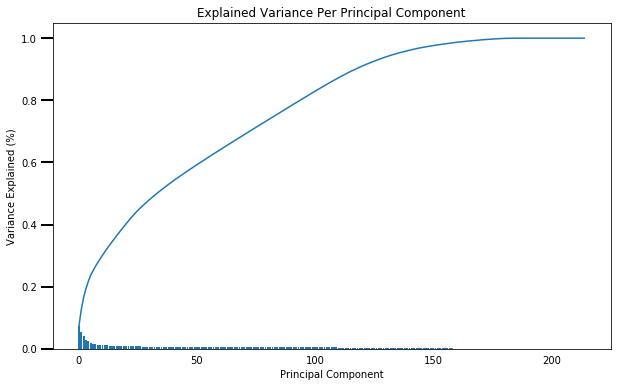

In [64]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
scree_plot(pca)

In [65]:
# We want to to keep at least 85% of the data how many components we need?
for n_components in range(1, len(cleaned_df.columns)):
    variance = sum(pca.explained_variance_ratio_[:n_components])
    if variance >= 0.85:
        break
print(f'We need {n_components} componetns to get 0.85 of variance')
    

We need 106 componetns to get 0.85 of variance


In [66]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=106)
pca_data = pca.fit_transform(norm_df)

### Discussion 2.2: Perform Dimensionality Reduction

As I wanted to put a exact number of variance ( 85%) the number is 106 components for next steps.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [53]:
from operator import itemgetter

def get_weights(pca, index_principal_component):
    weights = {}
    for n, feature in enumerate(norm_df.columns):
        weights[feature] = pca.components_[index_principal_component][n]
    
    sorted_weights = sorted(weights.items(), key=itemgetter(1), reverse=True)
    return sorted_weights

In [54]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
print(norm_df.columns[0])
pc1 = get_weights(pca, 0) 
pc1

ALTERSKATEGORIE_GROB


[('FINANZ_MINIMALIST', 0.18862157569343832),
 ('MOBI_REGIO', 0.17922170352965436),
 ('KBA05_ANTG1', 0.16738976002194894),
 ('PLZ8_ANTG1', 0.16693495632409602),
 ('KBA05_GBZ', 0.15656209615449676),
 ('LP_STATUS_FEIN_10.0', 0.1373580807532794),
 ('LP_STATUS_GROB_5.0', 0.1373580807532794),
 ('GREEN_AVANTGARDE', 0.13729618900297025),
 ('PLZ8_GBZ', 0.1337478633301338),
 ('KONSUMNAEHE', 0.12726020434258278),
 ('LIFE_STAGE', 0.12288254517205324),
 ('LP_LEBENSPHASE_GROB', 0.12091125857775013),
 ('FINANZ_VORSORGER', 0.11573988591534771),
 ('ALTERSKATEGORIE_GROB', 0.10742484564673799),
 ('INNENSTADT', 0.10595734065845594),
 ('ZABEOTYP_1', 0.098582515853994662),
 ('GEBAEUDETYP_1.0', 0.094733500759942732),
 ('NATIONALITAET_KZ_1.0', 0.092163730425339693),
 ('ANZ_PERSONEN', 0.091652937081405816),
 ('FINANZTYP_2', 0.091001862196588679),
 ('CAMEO_DEUG_2015_2', 0.09005749701588335),
 ('LP_STATUS_GROB_4.0', 0.080803623299298771),
 ('LP_STATUS_FEIN_9.0', 0.079330695337721815),
 ('GEBAEUDETYP_RASTER', 0.0

In [48]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(norm_df.columns[1])
pc2 = get_weights(pca, 1) 
pc2

ANREDE_KZ


[('FINANZ_VORSORGER', 0.17732223251773019),
 ('ALTERSKATEGORIE_GROB', 0.1767104408848244),
 ('SEMIO_ERL', 0.14111157704992769),
 ('RETOURTYP_BK_S', 0.1390170995492496),
 ('LP_STATUS_FEIN_1.0', 0.1301387531758417),
 ('PLZ8_BAUMAX', 0.12966256137553875),
 ('HH_EINKOMMEN_SCORE', 0.12703007269234209),
 ('SOHO_KZ_0.0', 0.12235560430849939),
 ('AGER_TYP_2.0', 0.11619649021759222),
 ('FINANZTYP_5', 0.11591912160808447),
 ('FINANZ_HAUSBAUER', 0.11448154965475921),
 ('NATIONALITAET_KZ_1.0', 0.10988702764403911),
 ('ORTSGR_KLS9', 0.10913207509452998),
 ('SEMIO_LUST', 0.10374948039177091),
 ('KBA05_BAUMAX', 0.10188709140312045),
 ('PLZ8_ANTG3', 0.097428360701359198),
 ('KBA05_ANTG4', 0.096693279124265466),
 ('LP_FAMILIE_FEIN_1.0', 0.095290610531495623),
 ('LP_FAMILIE_GROB_1.0', 0.095290610531495623),
 ('ANZ_HAUSHALTE_AKTIV', 0.09019035564957617),
 ('PLZ8_ANTG4', 0.088663265020404738),
 ('KBA05_ANTG3', 0.087028499727970318),
 ('LP_STATUS_GROB_1.0', 0.085602916401248605),
 ('ZABEOTYP_3', 0.08527154

In [49]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(norm_df.columns[2])
pc3 = get_weights(pca, 2) 
pc3

FINANZ_MINIMALIST


[('SOHO_KZ_0.0', 0.24136876904704313),
 ('SEMIO_KULT', 0.21422840461793921),
 ('SEMIO_VERT', 0.20501023370696553),
 ('SEMIO_SOZ', 0.19610455614258329),
 ('SEMIO_TRADV', 0.16252501862191593),
 ('OST_WEST_KZ_W', 0.14738295356754044),
 ('NATIONALITAET_KZ_1.0', 0.12103504939960433),
 ('ONLINE_AFFINITAET', 0.1203249579026073),
 ('FINANZTYP_1', 0.11839592941040172),
 ('HH_EINKOMMEN_SCORE', 0.11719986556836964),
 ('ZABEOTYP_4', 0.1126292964580093),
 ('SHOPPER_TYP_1.0', 0.10188579996613807),
 ('GEBURTSJAHR', 0.099399841171328857),
 ('ANZ_PERSONEN', 0.091609322779806879),
 ('VERS_TYP_1.0', 0.091232700464757538),
 ('KBA05_ANTG2', 0.086983338856925177),
 ('ZABEOTYP_1', 0.086588554469198886),
 ('KONSUMNAEHE', 0.085692562772848146),
 ('ZABEOTYP_5', 0.084851075969485559),
 ('LP_STATUS_GROB_1.0', 0.084591257436058553),
 ('PLZ8_BAUMAX', 0.081626970018672168),
 ('SHOPPER_TYP_0.0', 0.080112611205208725),
 ('LP_STATUS_FEIN_2.0', 0.078543210501024557),
 ('GEBAEUDETYP_1.0', 0.077825747930184097),
 ('CJT_GE

### Discussion 2.3: Interpret Principal Components

- For the first component `ALTERSKATEGORIE_GROB` ( estimated age), we have a positive relation `FINANZ_MINIMALIST` and negative `WEALTH`. That means that as we get older we get lower interest in minimalist, so more interest in money. Then with the negative correlation `WEALTH`  the wealth feature gets lower which means older = more wealth.

- In the second component `ANREDE_KZ` ( male or female) we have a positive correlation with `FINANZ_VORSORGER` which means that female have less though of being prepared ( money). Then in the negative side we have `FINANZ_UNAUFFAELLIGER` which means male are more conspicuous.

- In the third componenet `FINANZ_MINIMALIST` ( low financial interest) we have a positive correlation with `SOHO_KZ_0.0` which means that we have no interest on money we have a small office / home office. An with the negative correlation `ZABEOTYP_3` so more interest means that our energy consumption = fair supplied.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

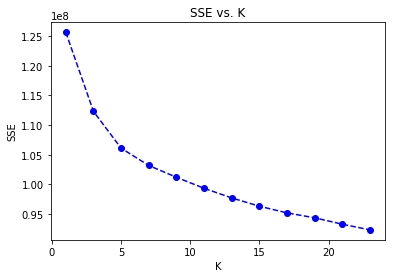

In [57]:
# Over a number of different cluster counts...

from sklearn.cluster import KMeans

def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

scores = []
centers = list(range(1, 25, 2))

for center in centers:
    scores.append(get_kmeans_score(pca_data, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [86]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
from sklearn.cluster import KMeans
model = KMeans(n_clusters=15)
model.fit(pca_data)
prediction = model.predict(pca_data)

### Discussion 3.1: Apply Clustering to General Population

We've selected 15 clusters

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [87]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')


In [88]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
cleaned_data = clean_data(customers)


start replacing Nan values...
finish replacing Nan values...
start re-encode, and engineer column values...
finish re-encode, and engineer column values...
removing columns..


In [76]:
[col for col in cleaned_df.columns if col not in cleaned_data.columns]

['TITEL_KZ_2.0', 'GEBAEUDETYP_5.0']

In [89]:
cleaned_data['TITEL_KZ_2.0'] = 0
cleaned_data['GEBAEUDETYP_5.0'] = 0

In [90]:
norm_cleaned_data = normalizer.transform(cleaned_data)
data_customer_scaled_pca = pca.transform(norm_cleaned_data)

In [91]:
pred_udacity = model.predict(data_customer_scaled_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

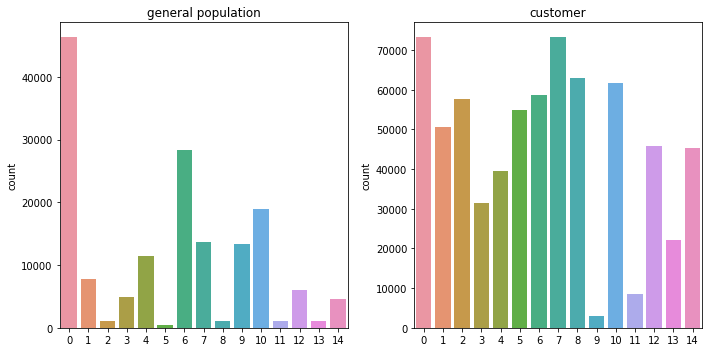

In [92]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
set(pred_udacity)
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.countplot(pred_udacity, ax=ax[0])
ax[0].set_title('general population')
sns.countplot(prediction, ax=ax[1])
ax[1].set_title('customer')
plt.tight_layout()

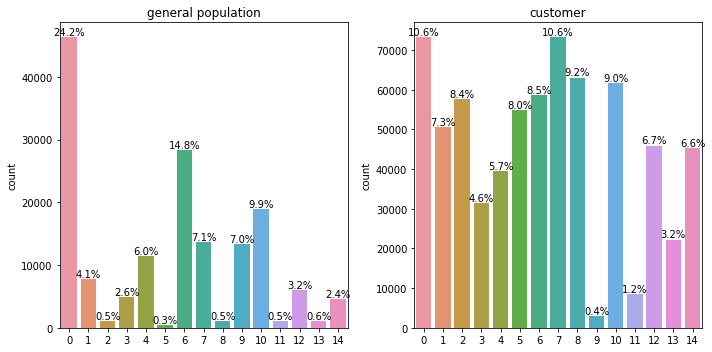

In [95]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.countplot(pred_udacity, ax=ax[0])
ax[0].set_title('general population')
sns.countplot(prediction, ax=ax[1])
ax[1].set_title('customer')
plt.tight_layout()
for p in ax[0].patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax[0].annotate('{:.1f}%'.format(100.*y/len(customers)), (x.mean(), y), 
            ha='center', va='bottom')
    
for p in ax[1].patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax[1].annotate('{:.1f}%'.format(100.*y/len(prediction)), (x.mean(), y), 
            ha='center', va='bottom')

In [102]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# In our case we select clusters: 8, 5, 2
customers = cleaned_df
customers['cluster'] = prediction
general_population = cleaned_data
general_population['cluster'] = pred_udacity

In [103]:
over = customers[customers['cluster'].isin([8, 5, 2])]
under = general_population[general_population['cluster'].isin([0, 6])]

In [109]:
over[over['cluster'] == 8].describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,AGER_TYP_1.0,AGER_TYP_2.0,AGER_TYP_3.0,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SOHO_KZ_0.0,SOHO_KZ_1.0,TITEL_KZ_1.0,TITEL_KZ_2.0,TITEL_KZ_3.0,TITEL_KZ_4.0,TITEL_KZ_5.0,VERS_TYP_1.0,VERS_TYP_2.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,KK_KUNDENTYP_1.0,KK_KUNDENTYP_2.0,KK_KUNDENTYP_3.0,KK_KUNDENTYP_4.0,KK_KUNDENTYP_5.0,KK_KUNDENTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,OST_WEST_KZ_O,OST_WEST_KZ_W,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE,cluster
count,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,63056.000000,

In [ ]:
# around 60s with money, young couple with children

In [110]:
over[over['cluster'] == 5].describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,AGER_TYP_1.0,AGER_TYP_2.0,AGER_TYP_3.0,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SOHO_KZ_0.0,SOHO_KZ_1.0,TITEL_KZ_1.0,TITEL_KZ_2.0,TITEL_KZ_3.0,TITEL_KZ_4.0,TITEL_KZ_5.0,VERS_TYP_1.0,VERS_TYP_2.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,KK_KUNDENTYP_1.0,KK_KUNDENTYP_2.0,KK_KUNDENTYP_3.0,KK_KUNDENTYP_4.0,KK_KUNDENTYP_5.0,KK_KUNDENTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,OST_WEST_KZ_O,OST_WEST_KZ_W,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE,cluster
count,54819.000000,54819.000000,54819.000000,54819.000000,54819.000000,54819.000000,54819.000000,54819.000000,54819.000000,54819.000000,54819.00000,54819.000000,54819.000000,54819.000000,54819.000000,54819.000000,54819.000000,54819.000000,54819.000000,54819.000000,54819.000000,54819.000000,54819.000000,54819.000000,54819.000000,54819.000000,54819.000000,54819.000000,54819.000000,54819.000000,54819.00000,54819.000000,54819.000000,54819.000000,54819.000000,54819.000000,54819.000000,54819.000000,54819.000000,54819.000000,54819.000000,54819.000000,54819.000000,54819.000000,54819.000000,54

In [ ]:
# arounds 60s with families

In [111]:
over[over['cluster'] == 2].describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,AGER_TYP_1.0,AGER_TYP_2.0,AGER_TYP_3.0,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SOHO_KZ_0.0,SOHO_KZ_1.0,TITEL_KZ_1.0,TITEL_KZ_2.0,TITEL_KZ_3.0,TITEL_KZ_4.0,TITEL_KZ_5.0,VERS_TYP_1.0,VERS_TYP_2.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,KK_KUNDENTYP_1.0,KK_KUNDENTYP_2.0,KK_KUNDENTYP_3.0,KK_KUNDENTYP_4.0,KK_KUNDENTYP_5.0,KK_KUNDENTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,OST_WEST_KZ_O,OST_WEST_KZ_W,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE,cluster
count,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,57621.000000,

In [ ]:
# Just checking the features that we added D(ecade, movement, wealth and life stage)
# we can say that people have loads of money and they born around 60s

In [107]:
under.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,AGER_TYP_1.0,AGER_TYP_2.0,AGER_TYP_3.0,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SOHO_KZ_0.0,SOHO_KZ_1.0,TITEL_KZ_1.0,TITEL_KZ_3.0,TITEL_KZ_4.0,TITEL_KZ_5.0,VERS_TYP_1.0,VERS_TYP_2.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,KK_KUNDENTYP_1.0,KK_KUNDENTYP_2.0,KK_KUNDENTYP_3.0,KK_KUNDENTYP_4.0,KK_KUNDENTYP_5.0,KK_KUNDENTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,OST_WEST_KZ_O,OST_WEST_KZ_W,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE,TITEL_KZ_2.0,GEBAEUDETYP_5.0,cluster
count,74749.000000,74749.000000,74749.000000,74749.000000,74749.000000,74749.000000,74749.000000,74749.000000,74749.000000,74749.0,74749.000000,74749.000000,74749.000000,74749.000000,74749.000000,74749.000000,74749.000000,74749.00000,74749.000000,74749.000000,74749.000000,74749.000000,74749.000000,74749.000000,74749.000000,74749.000000,74749.000000,74749.000000,74749.000000,74749.000000,74749.000000,74749.000000,74749.000000,74749.000000,74749.000000,74749.000000,74749.000000,74749.000000,74749.000000,74749.000000,74749.000000,74749.000000,74749.000000,74749.000000,74749.000000,74749.

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# In our case we select clusters: 0, 6

In [112]:
under[under['cluster'] == 0].describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,AGER_TYP_1.0,AGER_TYP_2.0,AGER_TYP_3.0,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SOHO_KZ_0.0,SOHO_KZ_1.0,TITEL_KZ_1.0,TITEL_KZ_3.0,TITEL_KZ_4.0,TITEL_KZ_5.0,VERS_TYP_1.0,VERS_TYP_2.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,KK_KUNDENTYP_1.0,KK_KUNDENTYP_2.0,KK_KUNDENTYP_3.0,KK_KUNDENTYP_4.0,KK_KUNDENTYP_5.0,KK_KUNDENTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,OST_WEST_KZ_O,OST_WEST_KZ_W,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE,TITEL_KZ_2.0,GEBAEUDETYP_5.0,cluster
count,46382.000000,46382.000000,46382.000000,46382.000000,46382.0,46382.000000,46382.000000,46382.000000,46382.000000,46382.0,46382.000000,46382.000000,46382.000000,46382.000000,46382.000000,46382.000000,46382.000000,46382.000000,46382.000000,46382.000000,46382.000000,46382.000000,46382.000000,46382.000000,46382.000000,46382.000000,46382.000000,46382.000000,46382.000000,46382.0,46382.000000,46382.0,46382.000000,46382.000000,46382.0,46382.000000,46382.000000,46382.000000,46382.000000,46382.000000,46382.0,46382.0,46382.0,46382.000000,46382.000000,46382.000000,46382.000000,46382.0,46382.

In [ ]:
# no money at all and ederly ( 40s) no wealth 

In [114]:
under[under['cluster'] == 6].describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,AGER_TYP_1.0,AGER_TYP_2.0,AGER_TYP_3.0,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SOHO_KZ_0.0,SOHO_KZ_1.0,TITEL_KZ_1.0,TITEL_KZ_3.0,TITEL_KZ_4.0,TITEL_KZ_5.0,VERS_TYP_1.0,VERS_TYP_2.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,KK_KUNDENTYP_1.0,KK_KUNDENTYP_2.0,KK_KUNDENTYP_3.0,KK_KUNDENTYP_4.0,KK_KUNDENTYP_5.0,KK_KUNDENTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,OST_WEST_KZ_O,OST_WEST_KZ_W,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE,TITEL_KZ_2.0,GEBAEUDETYP_5.0,cluster
count,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.0,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367

### Discussion 3.3: Compare Customer Data to Demographics Data


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

In [ ]:
# :) 